In [6]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../utils_mapping.R')
})


In [2]:
library(biomaRt)

# ID fibroblasts

## Load counts

In [3]:
sumOverRowNames <- function(X) {
    name_factors <- factor(row.names(X))
    res <- sumGroups(X, name_factors)
    row.names(res) <- levels(name_factors)[1:nrow(res)]
    colnames(res) <- colnames(X)
    return(res)
}


In [4]:
datadir <- '/data/srlab/ik936/NOTCH/data/GEO/processed'
exprs_list <- paste0('sample', 1:6) %>% map(function(sample_name) {
    message(sample_name)
    barcode.loc <- sprintf('%s/barcodes_%s.txt.gz', datadir, sample_name)
    gene.loc <- sprintf('%s/genes_%s.txt.gz', datadir, sample_name)
    matrix.loc <- sprintf('%s/counts_%s.mtx.gz', datadir, sample_name)
    data <- readMM(file = matrix.loc) %>% as("dgCMatrix")
    cell.names <- readLines(barcode.loc)
#     cell.names <- gsub("-1$", "", cell.names)    
    gene.names <- fread(gene.loc, header = FALSE)$V1
    row.names(data) <- gene.names
    colnames(data) <- cell.names
    return(as(sumOverRowNames(data), "dgCMatrix"))
})

exprs_raw <- Reduce(Matrix::cbind2, exprs_list)

sample1

sample2

sample3

sample4

sample5

sample6



In [1]:
dim(exprs_raw)
exprs_raw[1:5, 1:5]

ERROR: Error in eval(expr, envir, enclos): object 'exprs_raw' not found


## Metadata from previous analysis 

In [6]:
meta_data <- readRDS('/data/srlab/ik936/NOTCH/data/cache/mouse.rds')$meta_data

In [7]:
head(meta_data)

,cell_id,donor,nUMI,nGene,percent_mito,label,status,cell_type,score_notch
,<fct>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,AAACCTGTCGAACGGA_BRI062,BRI062,4976,1443,0.03758039,WT,case,sublining,39.09332
2,AAACCTGTCGGCTTGG_BRI062,BRI062,998,559,0.05511022,WT,case,lining,24.64387
3,AAACGGGCAAGTAATG_BRI062,BRI062,5414,1643,0.03472479,WT,case,tcell,12.46428
4,AAACGGGCACCTATCC_BRI062,BRI062,3169,1184,0.02776901,WT,case,sublining,26.65281
5,AAACGGGCATGCCTAA_BRI062,BRI062,1634,831,0.08200734,WT,case,sublining,26.19304
6,AAACGGGGTGAGTGAC_BRI062,BRI062,1952,999,0.03176230,WT,case,myeloid,13.29531


In [8]:
exprs_raw <- exprs_raw[, meta_data$cell_id]

Add broad disease activity categories

In [9]:
disease_classes_df <- meta_data %>% 
    dplyr::select(donor, label, status) %>% unique() %>% 
    dplyr::mutate(disease = case_when(
        status == 'case' & label %in% c('WT', 'ISO') ~ 'Inflam',
        TRUE ~ 'nonInflam'
    )) %>% 
    tidyr::unite(label_status, label, status) 


In [10]:
meta_data <- meta_data %>% 
    dplyr::left_join(disease_classes_df, by = 'donor')


In [11]:
head(meta_data)

,cell_id,donor,nUMI,nGene,percent_mito,label,status,cell_type,score_notch,label_status,disease
,<fct>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,AAACCTGTCGAACGGA_BRI062,BRI062,4976,1443,0.03758039,WT,case,sublining,39.09332,WT_case,Inflam
2,AAACCTGTCGGCTTGG_BRI062,BRI062,998,559,0.05511022,WT,case,lining,24.64387,WT_case,Inflam
3,AAACGGGCAAGTAATG_BRI062,BRI062,5414,1643,0.03472479,WT,case,tcell,12.46428,WT_case,Inflam
4,AAACGGGCACCTATCC_BRI062,BRI062,3169,1184,0.02776901,WT,case,sublining,26.65281,WT_case,Inflam
5,AAACGGGCATGCCTAA_BRI062,BRI062,1634,831,0.08200734,WT,case,sublining,26.19304,WT_case,Inflam
6,AAACGGGGTGAGTGAC_BRI062,BRI062,1952,999,0.03176230,WT,case,myeloid,13.29531,WT_case,Inflam


## QC

Picking joint bandwidth of 0.029



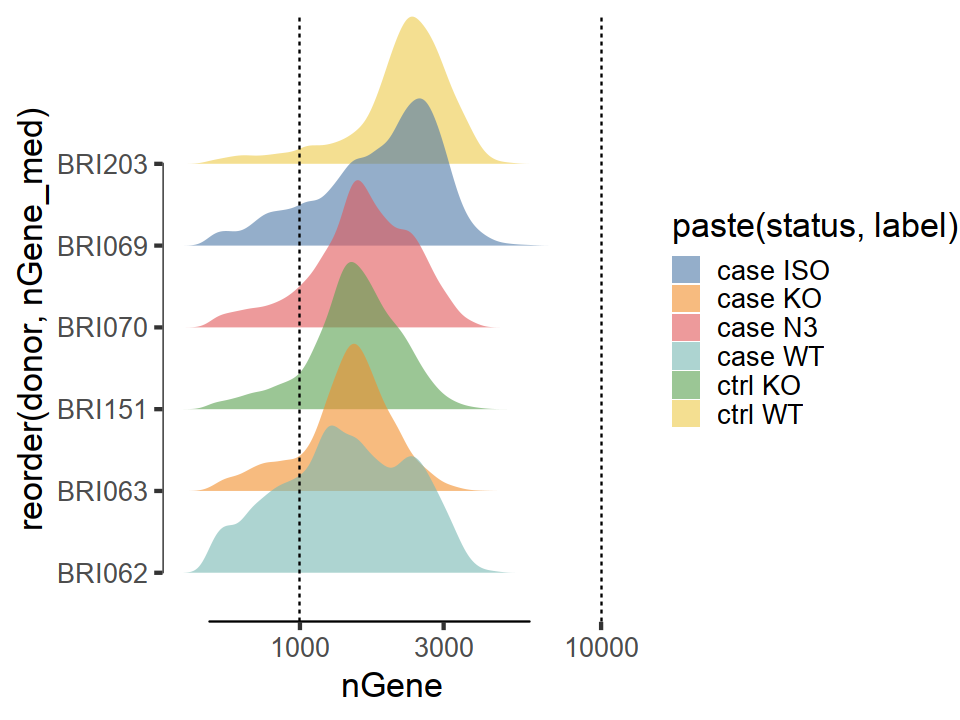

In [12]:
fig.size(6, 8)
# data.table(meta_data)[, nUMI_med := median(nUMI), by = LibraryID][] %>% 
#     ggplot(aes(nUMI, reorder(LibraryID, nUMI_med), fill = Case)) + 
data.table(meta_data)[, nGene_med := median(nGene), by = donor][] %>% 
    ggplot(aes(nGene, reorder(donor, nGene_med), fill = paste(status, label))) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        scale_x_continuous(trans = 'log10') + 
        geom_vline(xintercept = c(1e3, 1e4), linetype = 2) + 
        scale_fill_tableau() + 
        NULL


In [13]:
meta_data <- meta_data %>% 
    subset(nGene > 1000 & percent_mito < .2)

In [14]:
exprs_raw <- exprs_raw[, meta_data$cell_id]

## Map exprs_raw to human genes

In [15]:
human_genes <- rownames(readRDS('/data/srlab/ik936/Roche/data/cache/synovium_obj_stromal.rds')$exprs_raw)

In [16]:
exprs_raw_hs <- map_species(exprs_raw, human_genes, from='mouse', to='human', orthologs_table=NULL, round_fxn=identity)


No orthologues DF provided, pulling data from Biomart



In [17]:
dim(exprs_raw_hs)

[1] 17212 16060

In [18]:
dim(exprs_raw)

[1] 31017 16060

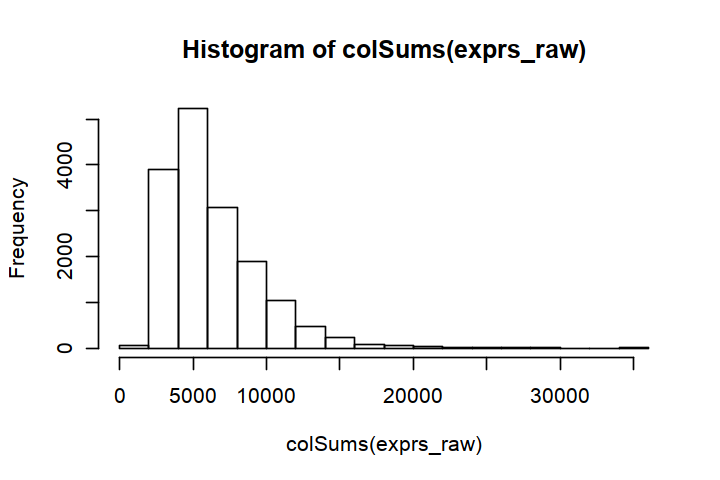

In [19]:
fig.size(4, 6)
hist(colSums(exprs_raw))

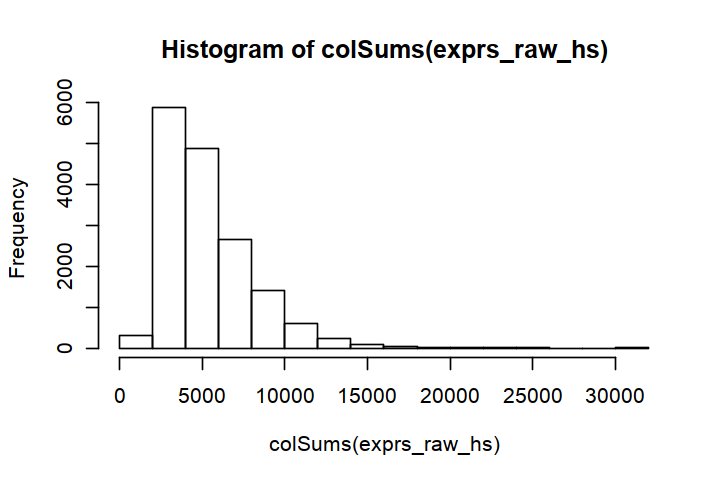

In [20]:
fig.size(4, 6)
hist(colSums(exprs_raw_hs))

In [21]:
obj <- list()
obj$exprs_raw <- exprs_raw
obj$meta_data <- meta_data
obj$exprs_raw_hs <- exprs_raw_hs

In [22]:
saveRDS(obj, '/data/srlab/ik936/Roche/data/cache/synovium_obj_mouse_all.rds')

# Lineage

In [ ]:
## we do not analyze healthy (non serum transfer mice in this paper)
obj <- readRDS('/data/srlab/ik936/Roche/data/cache/synovium_obj_mouse_all.rds')
idx <- which(obj$meta_data$status == 'case')
exprs_raw_hs <- obj$exprs_raw_hs


## Create object

In [ ]:
5

In [ ]:
fig.size(5, 8)
set.seed(1)
obj <- create_object(obj$exprs_raw[, idx], obj$meta_data[idx, ]) %>% 
    do_harmony(
        'LibraryID', theta=0.5, 
        max.iter.harmony=4, max.iter.cluster=20,
        epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
#         weights = m$weight,
        plot_convergence = TRUE
    ) %>% 
    do_cluster(c(.1, .2, .3, .4))


In [7]:
obj$exprs_raw_hs <- exprs_raw_hs[, idx]

start filter



ERROR: Error in exprs_raw[, meta_data$CellID]: invalid or not-yet-implemented 'Matrix' subsetting


In [ ]:
head(obj$meta_data)

Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”


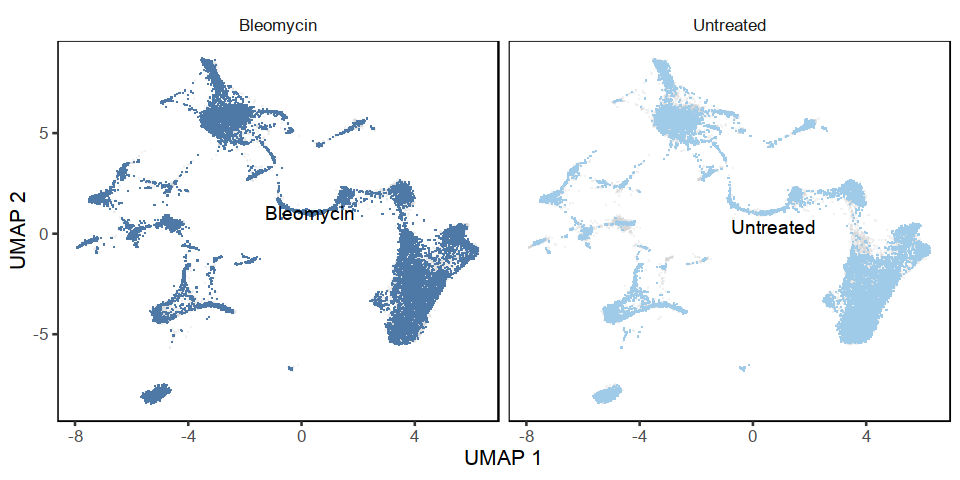

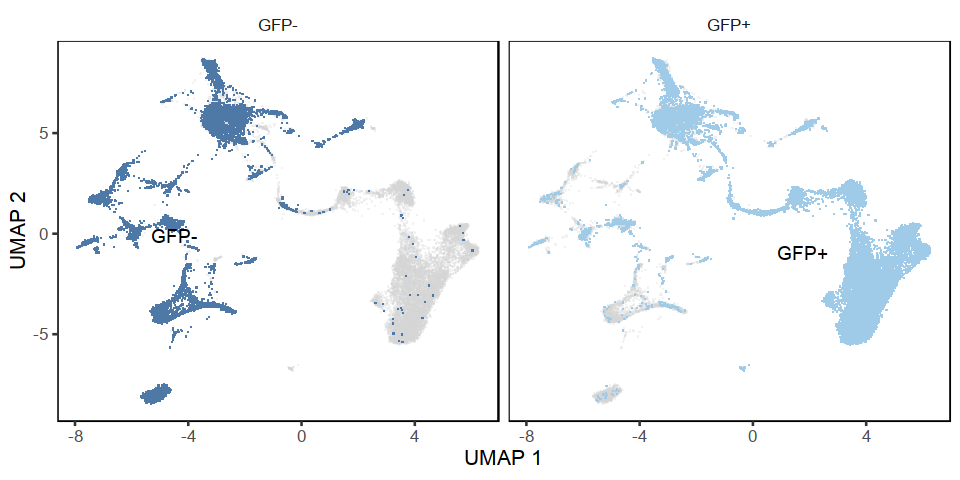

In [221]:
fig.size(4, 8)
do_scatter(obj$umap_after, obj$meta_data, 'Treatment', quo(Treatment))


## Lineage

In [6]:
lineage_markers <- list(
#     epithelial = c('EPCAM', 'CDH1'),
    endothelial = c('VWF', 'NOTCH4', 'PODXL'),
    mural = c('NOTCH3', 'ACTA2', 'MCAM', 'MYH11'),
    fibroblast = c('PDGFRA', 'PDPN', 'ABCA8', 'COL1A1'),
    haematopoietic = c('PTPRC', 'CD3E', 'CD79', 'LYVE1')
#     glial = c('CRYAB', 'S100B')
) %>% 
    map(stringr::str_to_sentence)


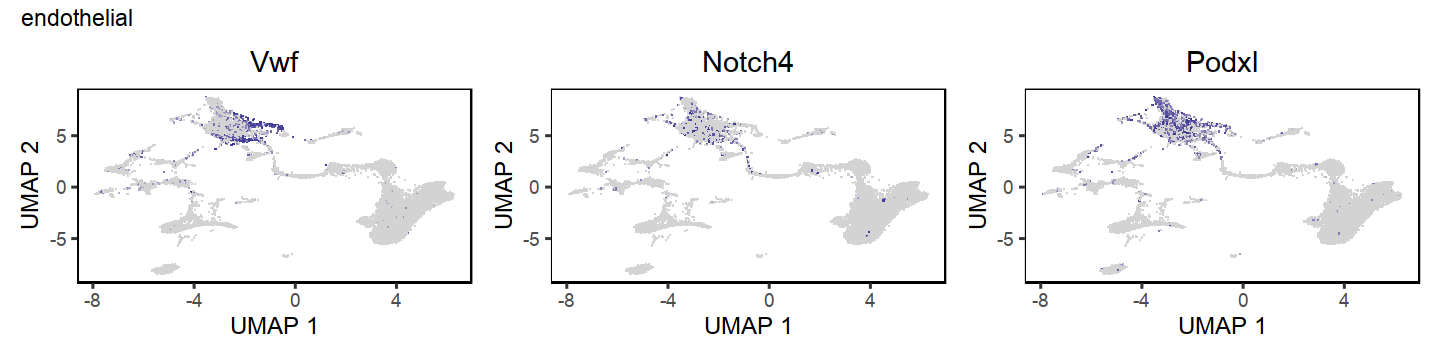

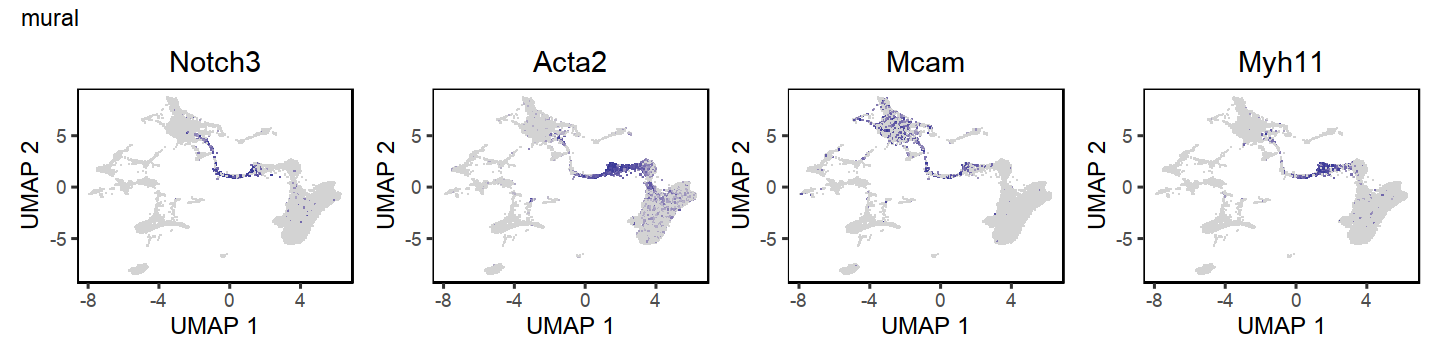

[[1]]

[[2]]

[[3]]

[[4]]


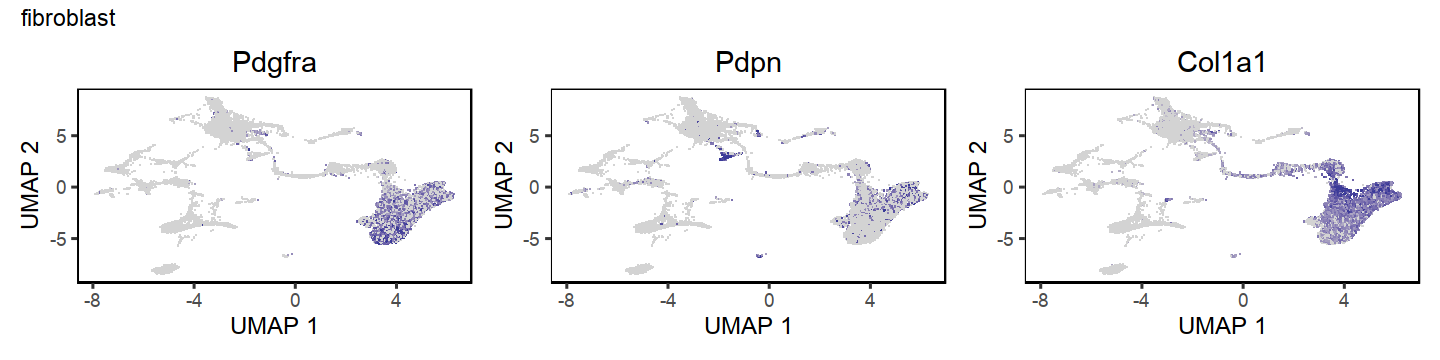

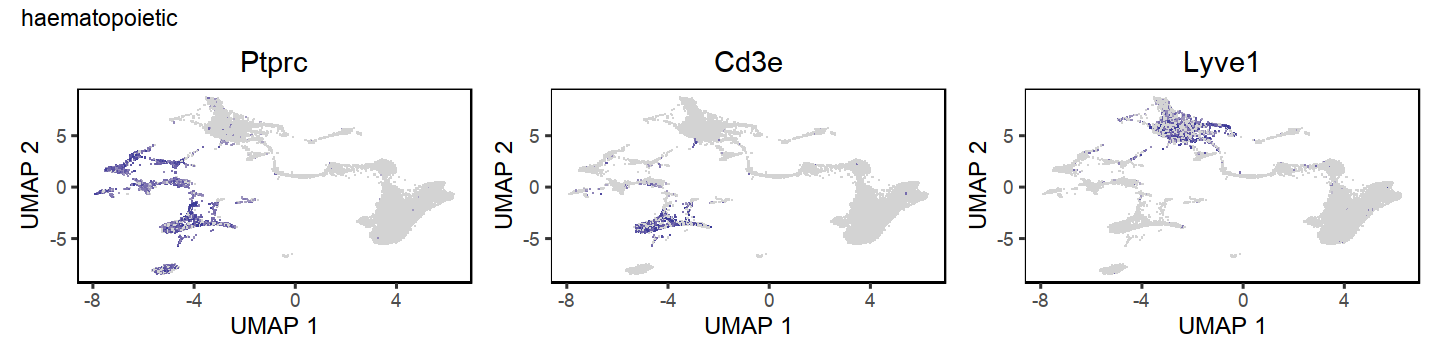

In [7]:
fig.size(3, 12)
with(obj, {
    lapply(names(lineage_markers), function(group) {
        plotFeatures(exprs_norm, umap_after,
                     intersect(lineage_markers[[group]], row.names(exprs_norm)), 
                     qhi = .99, no_guide = TRUE) + 
            plot_annotation(title = group)
    })    
})


In [127]:
# top_markers(obj$markers$res1)

Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


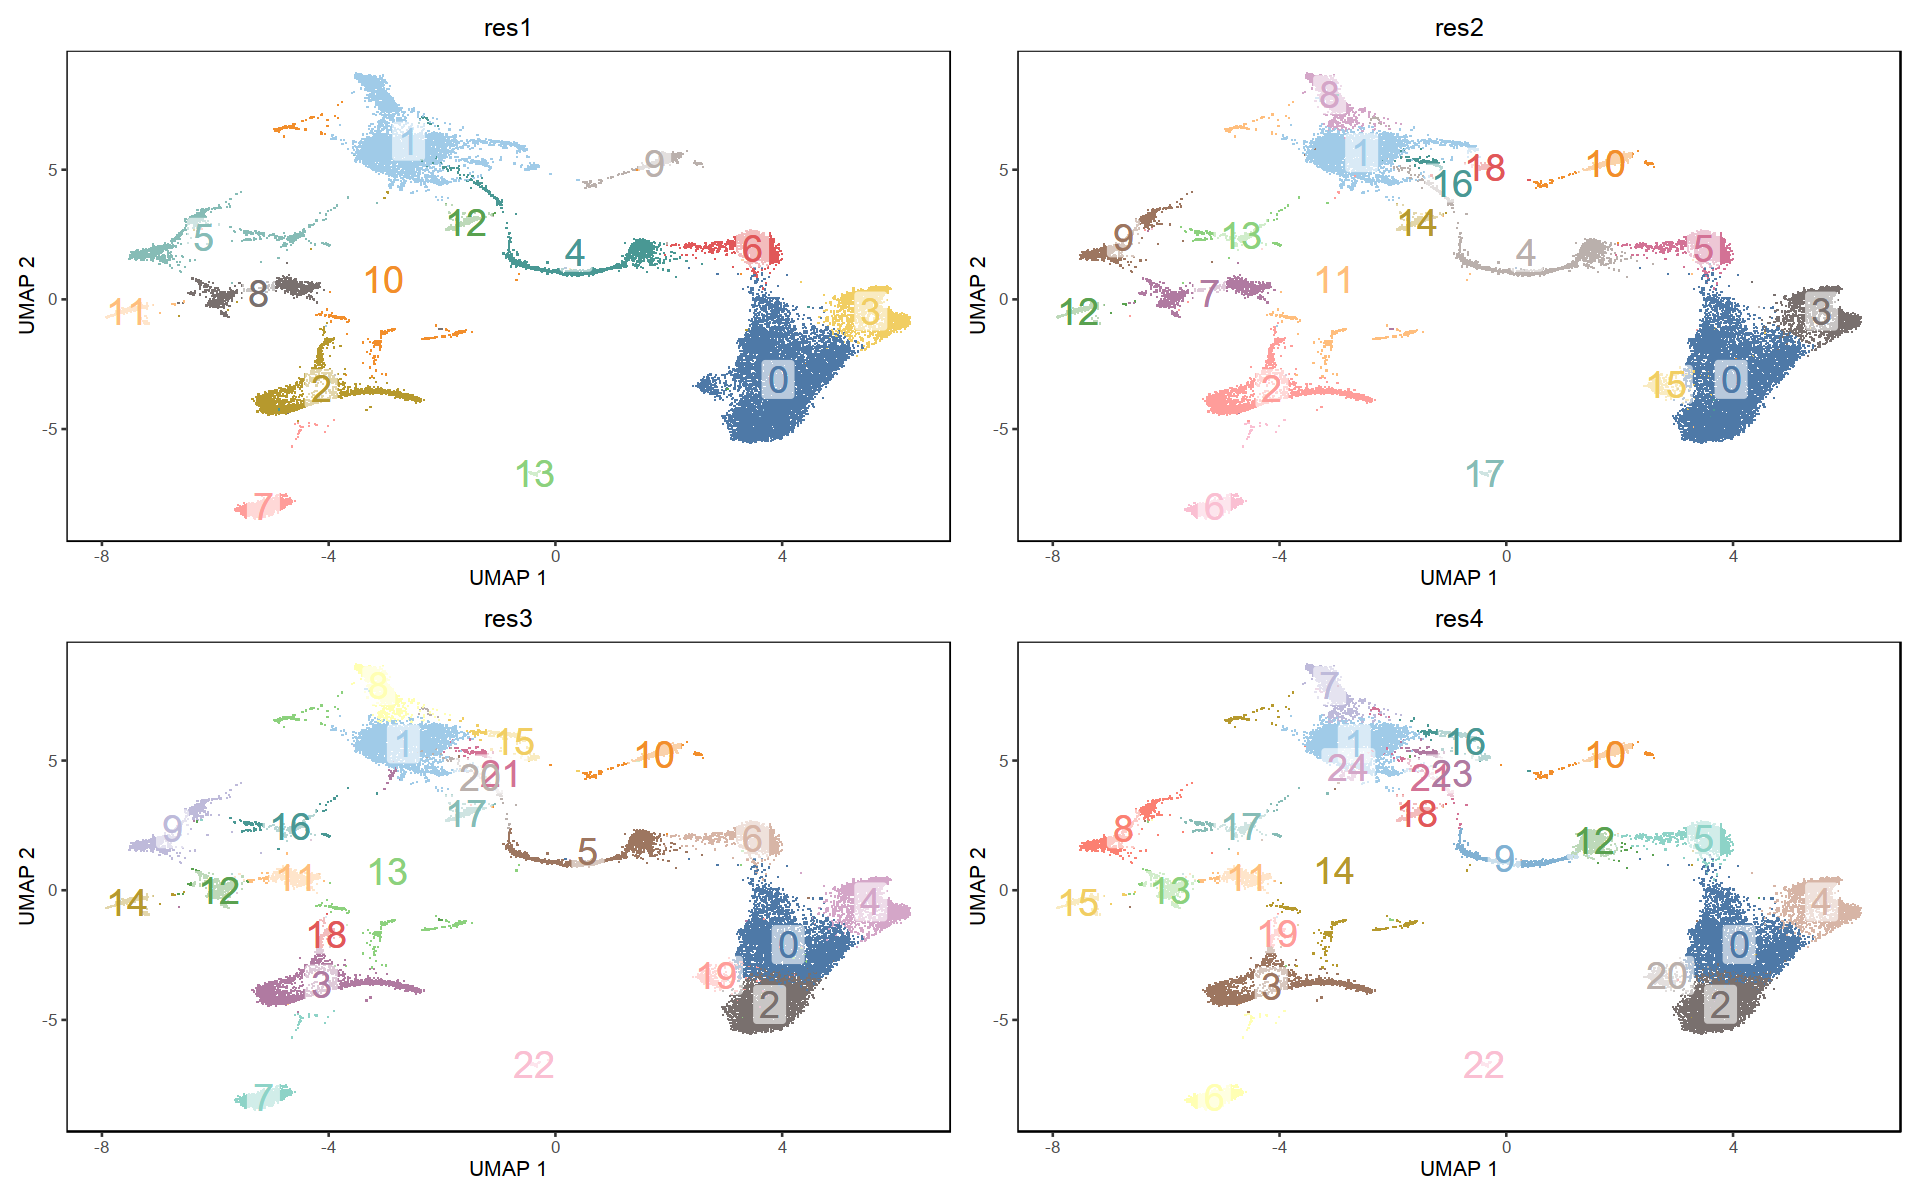

In [8]:
fig.size(10, 16)
plot_clusters(obj, 'umap_after')

In [122]:
obj$meta_data$lineage <- case_when(
    obj$clusters_df$res1 %in% c('1') ~ 'endothelial',
    obj$clusters_df$res1 %in% c('6') ~ 'myofibroblast',
    obj$clusters_df$res1 %in% c('0', '3') ~ 'fibroblast',
    obj$clusters_df$res1 %in% c('4') ~ 'mural',
    obj$clusters_df$res1 %in% c('11', '2', '5', '7', '8') ~ 'hematopoietic',
    TRUE ~ 'UNKNOWN'
)


Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


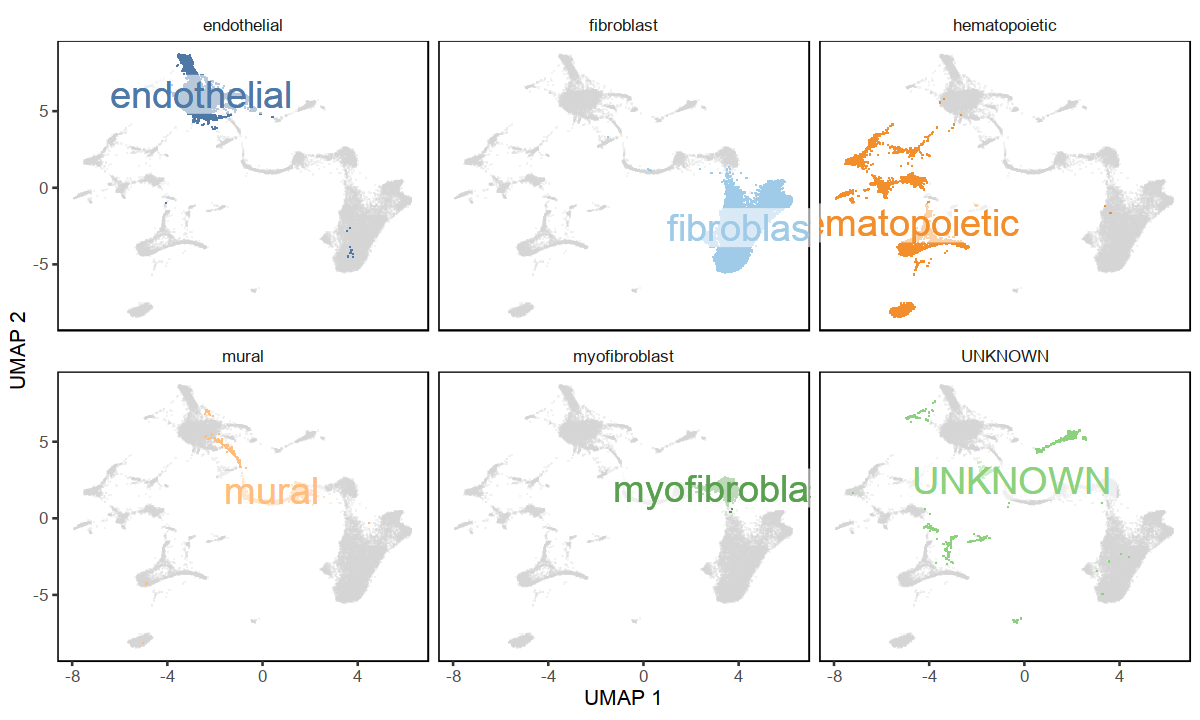

In [4]:
fig.size(6, 10)
# fig.size(5, 8)
do_scatter(obj$umap_after, obj$meta_data, 'lineage', quo(lineage), pt_size = 8, nrow = 2)


In [1]:
# obj <- readRDS('/data/srlab/ik936/Roche/data/cache/synovium_obj_mouse_all.rds')

# Cache

In [71]:
obj$query <- query_obj

In [72]:
saveRDS(obj, '/data/srlab/ik936/Roche/data/cache/synovium_obj_mouse_stromal.rds')

In [2]:
query_obj <- readRDS('/data/srlab/ik936/Roche/data/cache/synovium_obj_mouse_stromal.rds')$query_obj